In [403]:
import os
import torch
from PIL import Image
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import torchvision
from torchvision import models
from torch.utils.tensorboard import SummaryWriter 
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("MPS backend is not available.")


In [404]:
print(device)


mps


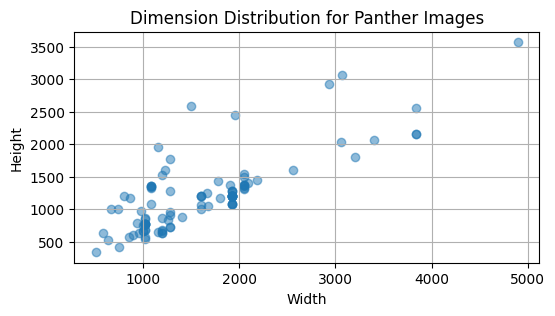

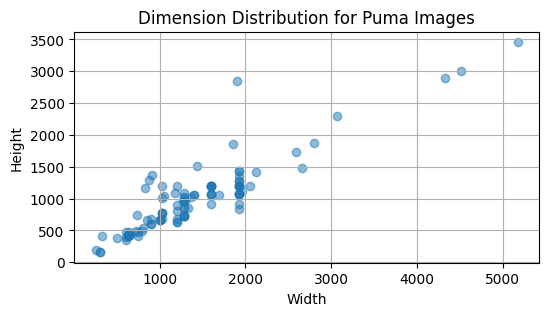

In [39]:
def get_image_dimensions(folder_name):
    dimensions = []
    files = os.listdir(folder_name)

    for filename in files:
        # Skip files like .DS_Store
        if filename.startswith('.'):
            continue
        file_path = os.path.join(folder_name, filename)
        with Image.open(file_path) as img:
            dimensions.append(img.size)  # (width, height)
            
    return dimensions

def plot_dimension_distribution(dimensions, title):
    widths, heights = zip(*dimensions)
    plt.figure(figsize=(6, 3))
    plt.scatter(widths, heights, alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title(f'Dimension Distribution for {title}')
    plt.grid(True)
    plt.show()


Pa_dimensions = get_image_dimensions('data_new/Panther')
plot_dimension_distribution(Pa_dimensions, 'Panther Images')
Pu_dimensions = get_image_dimensions('data_new/Puma')
plot_dimension_distribution(Pu_dimensions, 'Puma Images')


In [3]:
from PIL import Image
import os

def check_image_modes(folder_name):
    #list of all files in the folder
    files = os.listdir(folder_name)
    # checking the mode
    for filename in files:
        if filename.startswith('.'):  # Skip files like .DS_Store
            continue

        file_path = os.path.join(folder_name, filename)
        with Image.open(file_path) as img:
            print(f"Image: {filename}, Mode: {img.mode}")

# Check image modes in both folders
check_image_modes('data_new/Panther')
check_image_modes('data_new/Puma')


Image: Panther_48.jpg, Mode: RGB
Image: Panther_74.jpg, Mode: RGB
Image: Panther_60.jpg, Mode: RGB
Image: Panther_61.jpg, Mode: RGB
Image: Panther_75.jpg, Mode: RGB
Image: Panther_49.jpg, Mode: RGB
Image: Panther_63.jpg, Mode: RGB
Image: Panther_77.jpg, Mode: RGB
Image: Panther_88.jpg, Mode: RGB
Image: Panther_89.jpg, Mode: RGB
Image: Panther_76.jpg, Mode: RGB
Image: Panther_62.jpg, Mode: RGB
Image: Panther_66.jpg, Mode: RGB
Image: Panther_72.jpg, Mode: RGB
Image: Panther_99.jpg, Mode: RGB
Image: Panther_98.jpg, Mode: RGB
Image: Panther_73.jpg, Mode: RGB
Image: Panther_67.jpg, Mode: RGB
Image: Panther_71.jpg, Mode: RGB
Image: Panther_65.jpg, Mode: RGB
Image: Panther_59.jpg, Mode: P
Image: Panther_58.jpg, Mode: RGB
Image: Panther_64.jpg, Mode: RGB
Image: Panther_70.jpg, Mode: RGB
Image: Panther_17.jpg, Mode: RGB
Image: Panther_16.jpg, Mode: RGB
Image: Panther_28.jpg, Mode: RGB
Image: Panther_14.jpg, Mode: RGB
Image: Panther_15.jpg, Mode: RGB
Image: Panther_29.jpg, Mode: RGB
Image: Panth

In [4]:
def get_image_paths(folder):
    """Get all image paths in the folder."""
    return [os.path.join(folder, filename) for filename in os.listdir(folder) if filename.endswith('.jpg')]

Pa_images = get_image_paths('data_new/Panther')
Pu_images = get_image_paths('data_new/Puma')
print(len(Pa_images))
print(len(Pu_images))

100
100


In [42]:

    
def save_images(train_files, test_files, class_name, base_dir):
    """Save train and test tensors in respective directories."""
    # Creating train and test directories
    train_dir = os.path.join(base_dir, 'train', class_name)
    test_dir = os.path.join(base_dir, 'test', class_name)
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    # Saveing training set
    for i, file in enumerate(train_files):
        try:
            img = Image.open(file)  # Open the image using PIL
            if img.mode not in ("RGB", "L"):
               img = img.convert("RGB")
            img.save(os.path.join(train_dir, f'{class_name}_{i}.jpg'))  # Save the image as a PNG
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Saving test set 
    for i, file in enumerate(test_files):
        try:
            img = Image.open(file)  # Open the image using PIL
            if img.mode not in ("RGB"):
               img = img.convert("RGB")            
            img.save(os.path.join(test_dir, f'{class_name}_{i}.jpg'))  # Save the image as a PNG
        except Exception as e:
            print(f"Error processing {file}: {e}")


def process_and_save_images(base_dir):
    """Processing images from both classes and saving them in the train/test folders."""  
 
    class1_train, class1_test = train_test_split(Pa_images, test_size=0.2, random_state=42)
    class2_train, class2_test = train_test_split(Pu_images, test_size=0.2, random_state=42)
    
    # Save the images in the train/test directories
    save_images(class1_train, class1_test, 'Panther', base_dir)
    save_images(class2_train, class2_test, 'Puma', base_dir)






In [43]:
process_and_save_images('data_new')


#
#
#
#
#
#
#
#
#

In [451]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # This should come before Normalize
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Random color jitter
    transforms.RandomRotation(10),  # Random rotation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])




train_dataset = datasets.ImageFolder(root='data_new/train', transform=train_transform)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True
)

In [437]:
class_to_idx = train_dataset.class_to_idx
print("Class to index mapping:", class_to_idx)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("index to Class mapping:", idx_to_class)
print(idx_to_class[1])

Class to index mapping: {'Panther': 0, 'Puma': 1}
index to Class mapping: {0: 'Panther', 1: 'Puma'}
Puma


In [452]:



test_dataset = datasets.ImageFolder(root='data_new/test',transform=transform)
test_loader = DataLoader(test_dataset , batch_size = 40, shuffle=True)

#
#
#
#
#
#
#

In [343]:

from PIL import Image, ImageDraw, ImageFont
import io

def img_caption(images, predictions):
    annotated_images = []
    font = ImageFont.load_default()

    for i in range(len(images)):
        # Convert tensor to numpy array
        image = images[i].cpu().numpy()
        image = (image * 255).astype(np.uint8)  # Assuming the image is normalized in range [0, 1]

        # Ensure image is in the right format (H, W, C)
        if image.shape[0] == 1:  # If grayscale, expand to RGB
            image = np.stack((image,) * 3, axis=-1)
        elif image.shape[0] == 3:  # If already RGB, transpose to (H, W, C)
            image = np.transpose(image, (1, 2, 0))

        # Convert to PIL image
        pil_image = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_image)
        
        # Add text
        draw.text((10, 10), f'Pred: {predictions[i]}', fill="white", font=font)
        
        # Convert back to numpy array
        buf = io.BytesIO()
        pil_image.save(buf, format='PNG')
        annotated_image = np.array(Image.open(buf))
        
        annotated_images.append(annotated_image)
    
    return annotated_images

In [453]:
class VGG1B(nn.Module):
    def __init__(self):
        super(VGG1B, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 112 * 112, 128) 
        self.fc2 = nn.Linear(128, 1) 

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the pooling layer
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Use sigmoid for binary classification
        return x


class VGG3B(nn.Module):
    def __init__(self):
        super(VGG3B, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)  
        self.fc2 = nn.Linear(128, 1)  
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)    
        x = x.view(x.size(0), -1)  # Flatten the output from the pooling layer
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Use sigmoid for binary classification
        return x


In [454]:
for batch_id, (data, targets) in enumerate(train_loader):
    print(f'batch_no : {batch_id}-----> batch_size : {data.shape}      targets  = {targets.shape}')

batch_no : 0-----> batch_size : torch.Size([64, 3, 224, 224])      targets  = torch.Size([64])
batch_no : 1-----> batch_size : torch.Size([64, 3, 224, 224])      targets  = torch.Size([64])
batch_no : 2-----> batch_size : torch.Size([32, 3, 224, 224])      targets  = torch.Size([32])


In [455]:
model = VGG3B()
model.to(device)

criterion = nn.BCELoss() 
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


In [456]:
it_train = 0
losses = []
accuracies = []
test_accuracies = []
epochs = 20
writer = SummaryWriter(f'runs/VGG_3B_64_0.0001_aug')
for ep in range(epochs):
    model.train()
    correct_t = 0
    total_size = 0.0

    for batch_idx, (data, targets) in enumerate(train_loader):


        data = data.to(device)
        targets = targets.to(device).float()  
        
        optimizer.zero_grad()
        
        scores = model(data)  
        # print(f'output : {scores}-----> truth : {targets}')
        
        loss = criterion(scores.squeeze(), targets) 
        loss.backward()
        optimizer.step()
        losses.append(loss.item())


        targets = targets.view_as(scores)
        correct = ((scores>0.5) == targets).sum().item()
        # print(correct)
        correct_t+=correct
        acc_batch= float(correct)/float(data.shape[0])
        accuracies.append(acc_batch)
        total_size+= float(data.shape[0])
        # print(f'Batch : {batch_idx}------> Accuracy : {acc_batch}')
        writer.add_scalar('Training Loss vs Iteration', loss.item(), global_step = it_train)
        writer.add_scalar('Training Accuracy vs Iteration', acc_batch, global_step = it_train)
        it_train+=1


        model.eval()
        corr_test_t=0
        total_test = 0
        with torch.no_grad():       
                for idx, (inputs, labels) in enumerate(test_loader):
                    inputs = inputs.to(device)
                    labels = labels.to(device).float()
                    
                    outputs = model(inputs)
                
                    labels = labels.view_as(outputs)
                    predictions = (outputs > 0.5).int().tolist()
                    corr_test = ((outputs>0.5) == labels).sum().item()
                    corr_test_t+=corr_test
                    total_test+= float(inputs.shape[0])
                    # print(f'test output{outputs}  and  labels = {labels}------> test correct = {corr_test}')
                    inputs = inputs.cpu()
                    print(predictions[0][0])
                    


                    for i in range(len(inputs)):
                  
                            img_grid = torchvision.utils.make_grid(inputs[i])
                            predicted_class = predictions[i][0]
                            writer.add_image(f'Test_Image_{idx}_{i}_Predicted_Class_{idx_to_class[predicted_class]}', img_grid)       
    


                    
        print(f'test batch no.:{idx}-------> Correct = {corr_test_t}, total_test = {total_test}')
        test_accuracies.append(float(corr_test_t)/total_test)
        writer.add_scalar('Testing Accuracy vs Iteration', float(corr_test_t)/total_test, global_step = it_train)
        
    print(f'Epoch no.{ep+1} training accuracy   : {float(correct_t)/total_size}\n')
        
writer.close()       
        
        

0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.:0-------> Correct = 21, total_test = 40.0
Epoch no.1 training accuracy   : 0.5

0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.:0-------> Correct = 21, total_test = 40.0
Epoch no.2 training accuracy   : 0.5

0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.:0-------> Correct = 21, total_test = 40.0
Epoch no.3 training accuracy   : 0.5125

0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.:0-------> Correct = 21, total_test = 40.0
Epoch no.4 training accuracy   : 0.5375

0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.:0-------> Correct = 21, total_test = 40.0
0
test batch no.

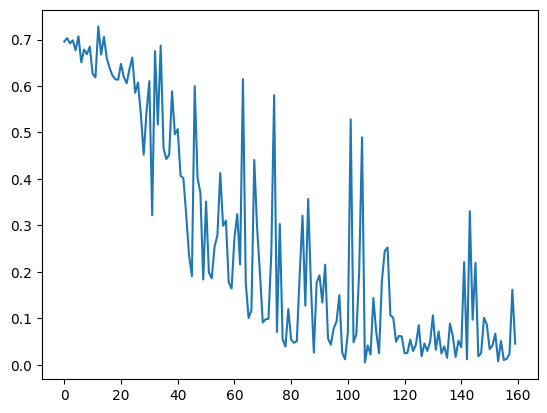

In [265]:
plt.plot(losses)

In [27]:
print(scores)
print(scores>0.5)
print(scores.shape)
print(targets.shape)
print((scores>0.5)==targets)

targets = targets.view_as(scores)
print((scores>0.5)==targets.squeeze())



tensor([[0.5141],
        [0.5315]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[True],
        [True]], device='mps:0')
torch.Size([2, 1])
torch.Size([2, 1])
tensor([[False],
        [ True]], device='mps:0')
tensor([[False,  True],
        [False,  True]], device='mps:0')


#
#
#
#
#

In [318]:
# Load a pre-trained VGG model
model = models.vgg16(pretrained=True)

# Freeze the convolutional layers
for param in model.features.parameters():
    param.requires_grad = False


# Modify the last fully connected layer to match the number of classes in your dataset


/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [321]:
# Get the number of input features for the last fully connected layer
num_features = model.classifier[6].in_features

num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(num_features, 1)
